In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib
import model.user as usr
import model.satellite as sat
#from random import randrange
import random
from tqdm.autonotebook import tqdm

from keras import layers
from keras.models import Model
from keras import backend as K
from keras import utils as np_utils
from keras import optimizers

import tensorflow as tf

<ipython-input-1-dc5f76e5262c>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Using TensorFlow backend.


In [2]:
class Agent(object):

    def __init__(self, input_dim, output_dim, hidden_dims=[32, 32]):
        """Gym Playing Agent
        Args:
            input_dim (int): the dimension of state.
                Same as `env.observation_space.shape[0]`
            output_dim (int): the number of discrete actions
                Same as `env.action_space.n`
            hidden_dims (list): hidden dimensions
        Methods:
            private:
                __build_train_fn -> None
                    It creates a train function
                    It's similar to defining `train_op` in Tensorflow
                __build_network -> None
                    It create a base model
                    Its output is each action probability
            public:
                get_action(state) -> action
                fit(state, action, reward) -> None
        """

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.__build_network(input_dim, output_dim, hidden_dims)
        self.__build_train_fn()

    def __build_network(self, input_dim, output_dim, hidden_dims=[32, 32]):
        """Create a base network"""
        self.X = layers.Input(shape=(input_dim,))
        net = self.X

        for h_dim in hidden_dims:
            net = layers.Dense(h_dim)(net)
            net = layers.Activation("relu")(net)

        net = layers.Dense(output_dim)(net)
        net = layers.Activation("softmax")(net)

        self.model = Model(inputs=self.X, outputs=net)
        print(self.model.summary())

    def __build_train_fn(self):
        """Create a train function
        It replaces `model.fit(X, y)` because we use the output of model and use it for training.
        For example, we need action placeholder
        called `action_one_hot` that stores, which action we took at state `s`.
        Hence, we can update the same action.
        This function will create
        `self.train_fn([state, action_one_hot, discount_reward])`
        which would train the model.
        """
        action_prob_placeholder = self.model.output
        action_onehot_placeholder = K.placeholder(shape=(None, self.output_dim),
                                                  name="action_onehot")
        discount_reward_placeholder = K.placeholder(shape=(None,),
                                                    name="discount_reward")

        action_prob = K.sum(action_prob_placeholder * action_onehot_placeholder, axis=1)
        log_action_prob = K.log(action_prob)

        loss = - log_action_prob * discount_reward_placeholder
        loss = K.mean(loss)

        adam = optimizers.Adam()

        updates = adam.get_updates(params=self.model.trainable_weights,
                                   # constraints=[],
                                   loss=loss)

        self.train_fn = K.function(inputs=[self.model.input,
                                           action_onehot_placeholder,
                                           discount_reward_placeholder],
                                   outputs=[self.model.output],
                                   updates=updates)

    def get_action(self, state):
        """Returns an action at given `state`
        Args:
            state (1-D or 2-D Array): It can be either 1-D array of shape (state_dimension, )
                or 2-D array shape of (n_samples, state_dimension)
        Returns:
            action: an integer action value ranging from 0 to (n_actions - 1)
        """
        shape = state.shape

        if len(shape) == 1:
            assert shape == (self.input_dim,), "{} != {}".format(shape, self.input_dim)
            state = np.expand_dims(state, axis=0)

        elif len(shape) == 2:
            assert shape[1] == (self.input_dim), "{} != {}".format(shape, self.input_dim)

        else:
            raise TypeError("Wrong state shape is given: {}".format(state.shape))

        action_prob = np.squeeze(self.model.predict(state))
        assert len(action_prob) == self.output_dim, "{} != {}".format(len(action_prob), self.output_dim)
        return np.random.choice(np.arange(self.output_dim), p=action_prob)

    def fit(self, S, A, R):
        """Train a network
        Args:
            S (2-D Array): `state` array of shape (n_samples, state_dimension)
            A (1-D Array): `action` array of shape (n_samples,)
                It's simply a list of int that stores which actions the agent chose
            R (1-D Array): `reward` array of shape (n_samples,)
                A reward is given after each action.
        """
        action_onehot = np_utils.to_categorical(A, num_classes=self.output_dim)
        discount_reward = compute_discounted_R(R, 0.99)

        assert S.shape[1] == self.input_dim, "{} != {}".format(S.shape[1], self.input_dim)
        assert action_onehot.shape[0] == S.shape[0], "{} != {}".format(action_onehot.shape[0], S.shape[0])
        assert action_onehot.shape[1] == self.output_dim, "{} != {}".format(action_onehot.shape[1], self.output_dim)
        assert len(discount_reward.shape) == 1, "{} != 1".format(len(discount_reward.shape))

        self.train_fn([S, action_onehot, discount_reward])


def compute_discounted_R(R, discount_rate=.99):
    """Returns discounted rewards
    Args:
        R (1-D array): a list of `reward` at each time step
        discount_rate (float): Will discount the future value by this rate
    Returns:
        discounted_r (1-D array): same shape as input `R`
            but the values are discounted
    Examples:
        >>> R = [1, 1, 1]
        >>> compute_discounted_R(R, .99) # before normalization
        [1 + 0.99 + 0.99**2, 1 + 0.99, 1]
    """
    discounted_r = np.zeros_like(R, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(R))):
        
        running_add = running_add * discount_rate + R[t]
        discounted_r[t] = running_add
        # print ("R[{}]: {}, running_add: {}".format(t,R[t], running_add))

    # if discounted_r.std() != 0:
    #     discounted_r -= (discounted_r.mean() / discounted_r.std())
    # else:
    discounted_r -= discounted_r.mean()

    return discounted_r

In [3]:
def run_episode(env, agent):  # , evolution):
    """Returns an episode reward
    (1) Play until the game is done
    (2) The agent will choose an action according to the policy
    (3) When it's done, it will train from the game play
    Args:
        env (gym.env): Gym environment
        agent (Agent): Game Playing Agent
    Returns:
        total_reward (int): total reward earned during the whole episode
    """
    done = False
    S = []
    A = []
    R = []

    old_state = env.state()
    s = old_state.reshape(6)

    total_reward = 0

    while not done:

        a = agent.get_action(s)

        new_state, r, done, info = env.step(a)
        total_reward += r

        # evolution.append([old_state, a, r])
        S.append(s)
        A.append(a)
        R.append(r)

        if done:
            new_state = env.advance()

            S_n = np.array(S)
            A_n = np.array(A)
            R_n = np.array(R)

            agent.fit(S_n, A_n, R_n)

        old_state = new_state
        s2 = new_state
        s = s2.reshape(6)

    return (total_reward / len(S))

In [4]:
tf.compat.v1.disable_eager_execution()
# simul, evolution = main()

beams = 3
env = sat.Satellite(beams)
input_dim = 2 * (beams)  # env.observation_space.shape[0]
output_dim = 1 * beams + 1  # env.action_space.n
agent = Agent(input_dim, output_dim, [16, 16])

rew_episodes = []
steps = 410
for episode in tqdm(range(200)):
    env = sat.Satellite(beams)
    rew = []
    for step in range(steps):
        reward = run_episode(env, agent)  # , evolution)
        # print(episode, step, reward)
        rew.append(reward)
    temp = sum(rew) / len(rew)
    print (temp)
    rew_episodes.append(temp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
____________________________________________

Widget Javascript not detected.  It may not be installed or enabled properly.


-1.1356604006195508
-1.3878177709900115
-1.3148393821936055
-1.5221509551483037
-1.2615042410031654
-0.9982152953995301
-1.0192284717713347
-0.9608874311498052
-1.154826806559496
-1.0791202169953977
-1.2504318635294267
-1.1217282225156104
-1.1635012497386243
-0.9475216368996868
-1.0642001847282665
-0.9569746066941186
-0.8605678738605586
-1.0460105150249022
-1.1260408145377667
-0.8713036905506434
-1.1770208214564089
-1.0086791535023256
-1.0681367125922279
-0.9019311846689919
-1.0869531177215903
-0.9273456208425727
-0.9851325540853976
-1.0719360419390913
-0.9505291260628422
-1.0234722005636638
-0.901914510963292
-1.0745853438566864
-0.8583830250959983
-0.9299099535288562
-1.0371782330135992
-0.854359368950834
-1.0131166726227714
-1.0391353693731753
-0.9290115792067026
-0.864195135487818
-0.8922805845915622
-1.0704717836364182
-0.9733652465420756
-1.1658826693958464
-1.0331507575158292
-1.094793566783493
-0.9132705939047406
-0.9243782395071867
-0.8654759617076686
-0.7786888308168834
-0.92

In [5]:
with open('training_1.txt', 'w') as f:
    for item in rew_episodes:
        f.write("%s\n" % item)

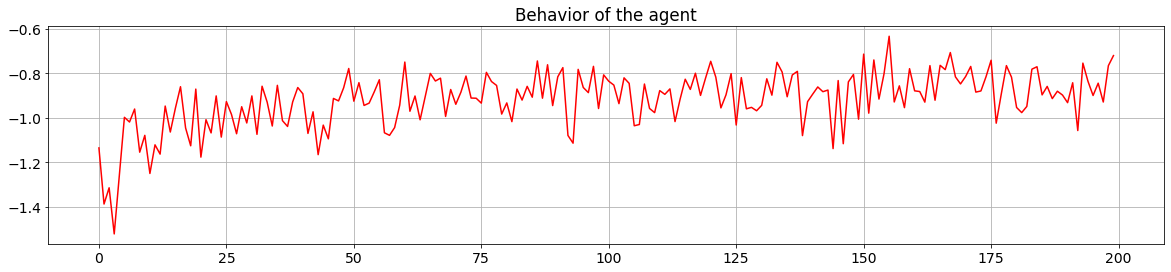

In [6]:
matplotlib.rcParams.update({'font.size': 14})

plt.figure(figsize=(20,4))
plt.plot(rew_episodes, color='red', label='Mean reward')
# plt.scatter(np.arange(len(rew)), rew, color='red', label='Actions dones')
# plt.bar(np.arange(len(simulation)), reward, color='blue', label='Reward')
plt.title('Behavior of the agent')
plt.grid()
#plt.legend()
#plt.savefig('Results')
#plt.xlim([0, 100])
plt.show()

In [7]:
simulation = []

for m in range(1):
    env = sat.Satellite(beams)
    for n in range(2000):
        if n == 0:
            old_state = env.state()
        done = False
        while not done:
            s = old_state.reshape(beams*2)
            action = agent.get_action(s)
            new_state, reward, done, info = env.step(action)
            if (done):
                simulation.append([old_state, action, reward])
                new_state = env.advance()
            old_state = new_state

In [8]:
# simulation

In [9]:
actions = []
in_service_0 = []
in_service_1 = []
in_service_2 = []
in_wait_0 = []
in_wait_1 = []
in_wait_2 = []
reward = []
for i in range(len(simulation)):
    # in_service_0.append(len(np.argwhere(np.array(simulation[i][0][0][1:]) > -1)))
    in_service_0.append(simulation[i][0][0][1])
    in_wait_0.append(simulation[i][0][0][0])
    # in_service_1.append(len(np.argwhere(np.array(simulation[i][0][1][1:]) > -1)))
    in_service_1.append(simulation[i][0][1][1])
    in_wait_1.append(simulation[i][0][1][0])
    in_service_2.append(simulation[i][0][2][1])
    in_wait_2.append(simulation[i][0][2][0])
    actions.append(simulation[i][1])
    reward.append(simulation[i][2])

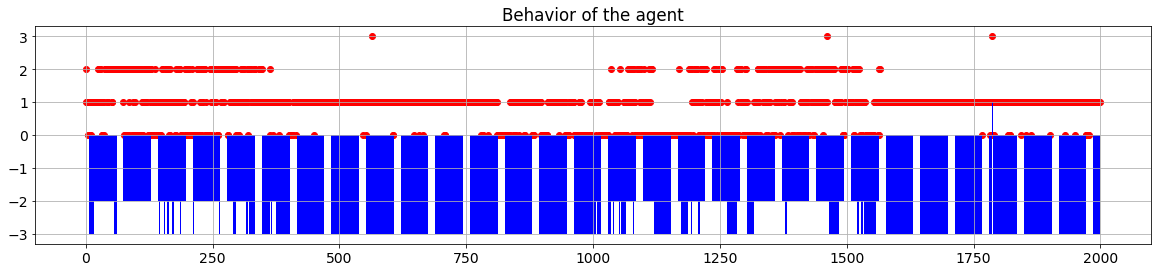

In [10]:
plt.figure(figsize=(20,4))
plt.scatter(np.arange(len(simulation)), actions, color='red', label='Actions dones')
plt.bar(np.arange(len(simulation)), reward, color='blue', label='Reward')
plt.title('Behavior of the agent')
plt.grid()
#plt.legend()
#plt.savefig('Results')
#plt.xlim([0, 100])
plt.show()

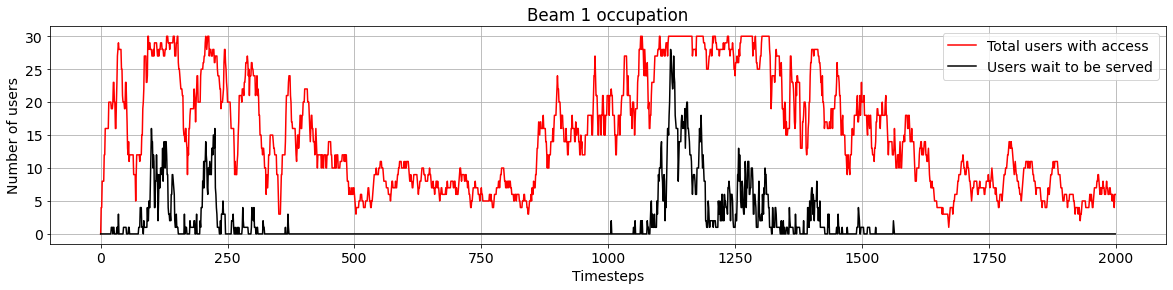

In [11]:
plt.figure(figsize=(20,4))
plt.plot(in_service_0, color='red', label='Total users with access')
plt.plot(in_wait_0, color='black', label='Users wait to be served')
plt.title('Beam 1 occupation')
plt.grid()
plt.legend()
plt.savefig('Results')
# plt.ylim([0, 80])
plt.xlabel("Timesteps")
plt.ylabel("Number of users")
plt.show()

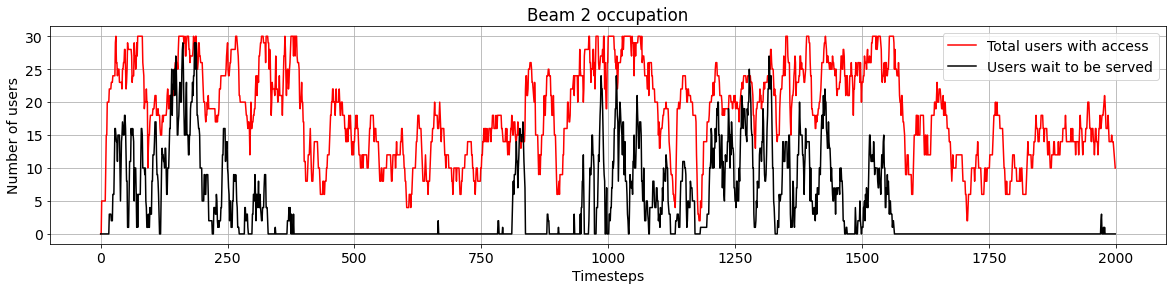

In [12]:
plt.figure(figsize=(20,4))
plt.plot(in_service_1, color='red', label='Total users with access')
plt.plot(in_wait_1, color='black', label='Users wait to be served')
plt.title('Beam 2 occupation')
plt.grid()
plt.legend()
plt.savefig('Results')
# plt.ylim([0, 80])
plt.xlabel("Timesteps")
plt.ylabel("Number of users")
plt.show()

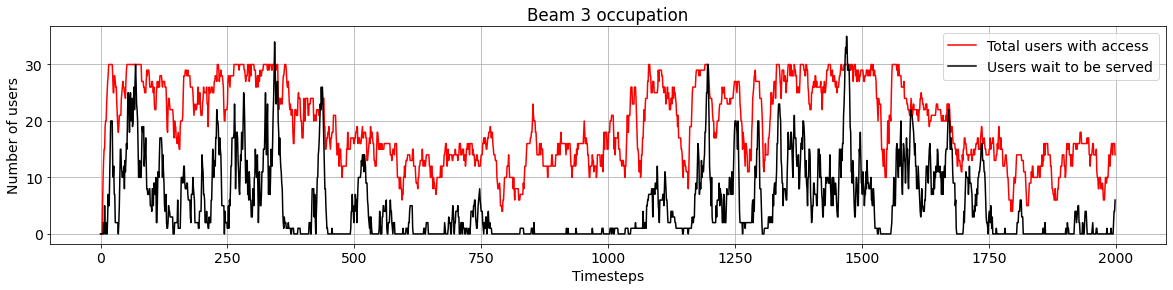

In [13]:
plt.figure(figsize=(20,4))
plt.plot(in_service_2, color='red', label='Total users with access')
plt.plot(in_wait_2, color='black', label='Users wait to be served')
plt.title('Beam 3 occupation')
plt.grid()
plt.legend()
plt.savefig('Results')
# plt.ylim([0, 80])
plt.xlabel("Timesteps")
plt.ylabel("Number of users")
plt.show()

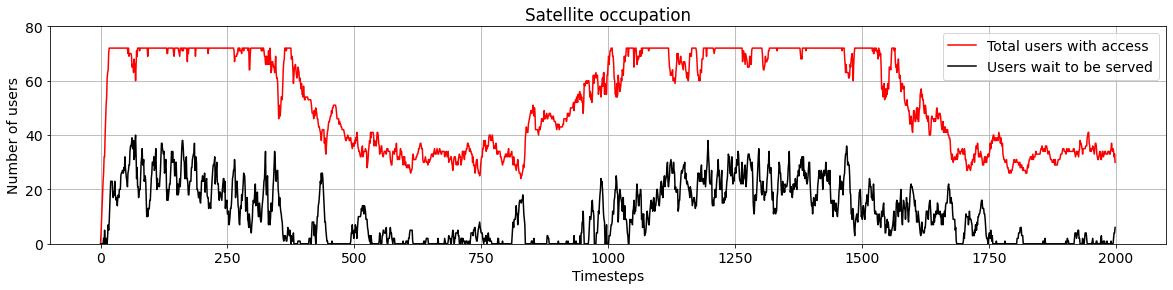

In [14]:
total_user_in_service = np.asarray(in_service_0) + np.asarray(in_service_1) + np.asarray(in_service_2)
total_user_in_wait = np.asarray(in_wait_0) + np.asarray(in_wait_1) + np.asarray(in_wait_2)

plt.figure(figsize=(20,4))
plt.plot(total_user_in_service, color='red', label='Total users with access')
plt.plot(total_user_in_wait, color='black', label='Users wait to be served')
plt.title('Satellite occupation')
plt.grid()
plt.legend()
plt.savefig('Results')
plt.ylim([0, 80])
plt.xlabel("Timesteps")
plt.ylabel("Number of users")
plt.show()

<ipython-input-15-3aaa77dd1701>:6: RuntimeWarning: invalid value encountered in double_scalars
  occupation.append(total_user_in_service[i] / (total_user_in_service[i] + total_user_in_wait[i]))


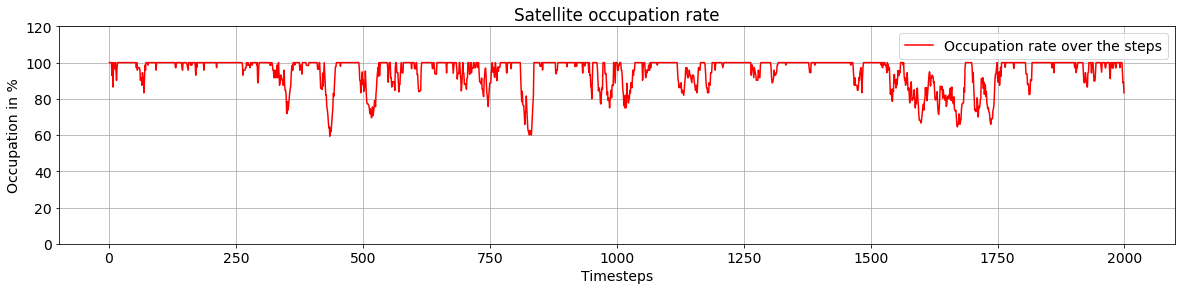

In [15]:
occupation = []
for i in range(len(total_user_in_service)):
    if total_user_in_service[i] + total_user_in_wait[i] > 24 * beams:
        occupation.append(total_user_in_service[i] / (24 * beams))
    else:
        occupation.append(total_user_in_service[i] / (total_user_in_service[i] + total_user_in_wait[i]))

plt.figure(figsize=(20,4))
plt.plot(np.asarray(occupation) * 100, color='red', label='Occupation rate over the steps')
# plt.bar(np.arange(len(occupation)), np.asarray(occupation) * 100, color='blue')
plt.title('Satellite occupation rate')
plt.grid()
plt.legend()
# plt.savefig('Results')
plt.ylim([0, 120])
plt.xlabel("Timesteps")
plt.ylabel("Occupation in %")
# plt.xlim([0, 250])
plt.show()